## HMcode demo

Here we compare the `HMcode` power spectrum from `pyHMcode` to that from `CAMB` and to the halo-model (from `pyhalomodel`).

First, import the necessary libraries

In [1]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import camb
import pyhalomodel as halo
import hmcode

Set some parameters

In [2]:
# Cosmology
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
ns = 0.96
sigma_8 = 0.8
w0 = -1.
wa = 0.
m_nu = 0.
norm_sigma8 = True
As = 2e-9

# CAMB
kmax_CAMB = 200.

# Wavenumbers [h/Mpc]
kmin, kmax = 1e-3, 1e1
nk = 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshifts
zs = [3., 2., 1., 0.5, 0.]
zs = np.array(zs)

# Halo masses [Msun/h] (for halo model only)
Mmin, Mmax = 1e0, 1e18
nM = 256
M = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

Run `CAMB` to get the linear spectrum and $\sigma(R)$

In [3]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams(WantCls=False)
wb, wc = Omega_b*h**2, Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=zs, kmax=kmax_CAMB) # Setup the linear matter power spectrum
Omega_m = pars.omegam # Extract the matter density

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if norm_sigma8:
    results = camb.get_results(pars)
    sigma_8_init = results.get_sigma8_0()
    print('Running CAMB')
    print('Initial sigma_8:', sigma_8_init)
    print('Desired sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Run
results = camb.get_results(pars)
Pk_lin_interp = results.get_matter_power_interpolator(nonlinear=False).P
Pk_nonlin_interp = results.get_matter_power_interpolator(nonlinear=True).P
sigma_8 = results.get_sigma8_0()
print('Final sigma_8:', sigma_8)

# Arrays for CAMB non-linear spectrum
Pk_CAMB = np.zeros((len(zs), len(k)))
for iz, z in enumerate(zs):
    Pk_CAMB[iz, :] = Pk_nonlin_interp(z, k)

Running CAMB
Initial sigma_8: 0.8051418118154231
Desired sigma_8: 0.8
Final sigma_8: 0.8


Get the `HMcode` spectrum, note that it takes the results data structure from `CAMB` as an argument

In [4]:
# Get the new HMcode spectrum
Pk_HMcode = hmcode.power(k, zs, results, verbose=True)

HMcode parameters
Halo mass range: 10^0.0 -> 10^18.0 Msun/h
Omega_m: 0.3
Neutrino mass fraction: 0.00%
Linear growth at z=0: 0.779

Redshift: 3.0
Scale factor: 0.25
Omega_m(z): 0.964
Un-normalisaed growth (= a for a << 1): 0.248
Normalised growth (= 1 at z = 0): 0.319
Accumulated growth (= a for a << 1): 0.25
Linear collapse threshold: 1.686
Virial halo overdensity: 180.0
Lagrangian radius range: 0.0001421 -> 142.1 Mpc/h
RMS in matter field range: 4.18 -> 0.01303
Peak height range: 0.4034 -> 129.4
Non-linear Lagrangian radius: 0.07868 Mpc/h
RMS in matter field at 8 Mpc/h: 0.2552
RMS in matter displacement field: 1.856 Mpc/h
Effective index at collapse scale: -2.511
Two-halo damping wavenumber; kd: 0.2522 h/Mpc
Two-halo fractional damping; f: 0.07465
Two-halo damping power; nd: 2.853
One-halo damping wavenumber; k*: 0.2241 h/Mpc
Halo bloating; eta: 0.2107
Minimum halo concentration; B: 5.196
Transition smoothing; alpha: 0.5733

Redshift: 2.0
Scale factor: 0.333
Omega_m(z): 0.92
Un-norma

Calculate the halo-model matter-matter power spectrum using `pyhalomodel`

In [5]:
# Normalised Fourier transform for an NFW profile
def win_NFW(k:np.ndarray, rv:np.ndarray, c:np.ndarray) -> np.ndarray:
    from scipy.special import sici
    rs = rv/c
    kv = np.outer(k, rv)
    ks = np.outer(k, rs)
    Sisv, Cisv = sici(ks+kv)
    Sis, Cis = sici(ks)
    f1 = np.cos(ks)*(Cisv-Cis)
    f2 = np.sin(ks)*(Sisv-Sis)
    f3 = np.sin(kv)/(ks+kv)
    f4 = np.log(1.+c)-c/(1.+c)
    Wk = (f1+f2-f3)/f4
    return Wk

# Halo model spectrum
Pk_hm = []
for iz, z in enumerate(zs):

    # Initialize
    hmod = halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=200., dc=1.686)

    # Halo profiles
    R = hmod.Lagrangian_radius(M)
    rv = hmod.virial_radius(M)
    c = 10.14*(M/2e12)**-0.081*(1.+z)**-1.01 # Duffy et al. (2008) concentration for M200 relaxed haloes
    Uk = win_NFW(k, rv, c) # NFW profile Fourier transform
    matter_profile = halo.profile.Fourier(k, M, Uk, amplitude=M, normalisation=hmod.rhom, mass_tracer=True)

    # Power spectra
    Pk_lin = Pk_lin_interp(z, k)
    sigmaM = results.get_sigmaR(R, z_indices=[iz])[0]
    _, _, Pk = hmod.power_spectrum(k, Pk_lin, M, sigmaM, {'m': matter_profile})
    Pk_hm.append(Pk['m-m'])

Plot the results

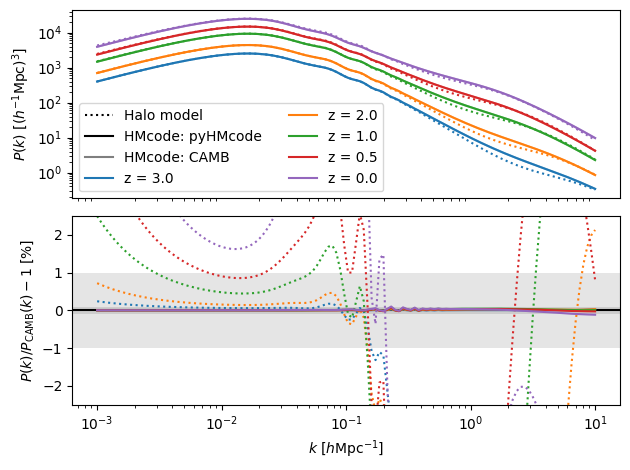

In [7]:
# Initialize
plt.subplots(2, 1)
dr = 2.5 # Per-cent

# Power
plt.subplot(2, 1, 1)
plt.plot(np.nan, color='black', ls=':', label='Halo model')
plt.plot(np.nan, color='black', label='HMcode: pyHMcode')
plt.plot(np.nan, color='black', alpha=0.5, label='HMcode: CAMB')
for iz, z in enumerate(zs):
    plt.loglog(k, Pk_hm[iz], ls=':', color='C%d'%iz)
    plt.loglog(k, Pk_HMcode[iz, :], color='C%d'%iz, label='z = %1.1f'%z)
    plt.loglog(k, Pk_CAMB[iz, :], alpha=0.5, color='C%d'%iz)
plt.xticks([])
plt.ylabel('$P(k)$ $[(h^{-1}\mathrm{Mpc})^3]$')
plt.legend(ncol=2)

# Ratio
plt.subplot(2, 1, 2)
plt.axhspan(-1., 1., color='black', alpha=0.1, lw=0.)
plt.axhspan(-0.1, 0.1, color='black', alpha=0.1, lw=0.)
plt.axhline(0., color='black')
for iz, _ in enumerate(zs):
    plt.semilogx(k, 100.*(-1.+Pk_hm[iz]/Pk_CAMB[iz, :]), ls=':', color='C%d'%iz)
    plt.semilogx(k, 100.*(-1.+Pk_HMcode[iz, :]/Pk_CAMB[iz, :]), color='C%d'%iz)
plt.xlabel('$k$ $[h\mathrm{Mpc}^{-1}]$')
plt.ylabel('$P(k)/P_\mathrm{CAMB}(k)-1$ [%]')
plt.ylim((-dr, dr))

# Finalize
plt.tight_layout()
plt.show()